# Ejemplo de ejecución para generar imágenes en tiempo real

## Canal de vapor de agua de ABI/GOES-16 y barbas de velocidad en niveles medios GFS.

En esta notebook de ejemplo se muestra la interacción de distintas fuentes de informacón provistas por Unidata para generar dos figuras como _plantilla_ pero que pueden editarse rápidamente con el conjunto de parámetros que se presentarán a continuación.

Se asume que esta notebook será ejecutada en Google Colab por lo que muchas de las bibliotecas de python ya se encuentran instaladas en la instancia de ejecución de Colab.

- Primero se instalan algunas bibliotecas obligatorias; en este caso `pip` se encarga de resolver las dependencias necesarias.
- Es posible que sea necesario ejetutar esta celda dos veces si aparece algún error.
- Es necesario prestar atención a los mensajes por si hace falta reiniciar el entorno de ejecución; esto no afecta a la ejecución posterior del código.
- En ocasiones es necesario instalar GDAL y Proj a nivel sistema usando `apt-get`.

Luego se detallan los `import` 

In [ ]:
!pip install python-awips
!pip install metpy
!pip install siphon

#!apt-get install -qq libgdal-dev libproj-dev
!pip install --no-binary shapely shapely --force
!pip install cartopy

In [1]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import cartopy
print(cartopy.__version__)  # por algunas dependencias es necesario saber la API disponible de Cartopy
import cartopy.crs as ccrs
from shapely.geometry import Polygon
import numpy as np
import scipy.ndimage as ndimage

from awips.dataaccess import DataAccessLayer
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange

from metpy.calc import wind_components
import metpy.calc as mpcalc
from metpy.plots import StationPlot, StationPlotLayout
from metpy.units import units

from siphon.catalog import TDSCatalog
import netCDF4
from netCDF4 import num2date

0.19.0.post1


## Datos de python-awips

En esta primera etapa se presenta a modo de resumen la descarga del Canal 8 del ABI/GOES-16 (vapor de agua de niveles altos) utilizando el servicio EDEX en la nube proporcionado por Unidata.

También se mustra cómo solicitar un recorte de la información a descargar para evitar trabajar con archivos/datos excesivamente grandes. Esto puede ser de importancia si se desea ejecutar de forma local.

### GOES-16/ABI

In [2]:
# Por primera vez digo cual es el servidor EDEX al cual conectarse
edex_url = 'edex-cloud.unidata.ucar.edu'
DataAccessLayer.changeEDEXHost(edex_url)

# Genero un nuevo request para un producto particular
# con las condiciones deseadas, en este caso datos de satélite
# para los datos del Full Disk del GOES-Este y el canal 8
sat_request = DataAccessLayer.newDataRequest()
sat_request.setDatatype('satellite')
sat_request.setLocationNames('EFD')
sat_request.setParameters('CH-08-6.19um')

# Se arma un Polygon de shapely para agregar al request y pedir un
# recorte de los datos.
# LON-W LON-E LAT-S LAT-N
bbox = [-100, -20, -70, 0]
envelope = Polygon([(bbox[0],bbox[2]),(bbox[0],bbox[3]),
                    (bbox[1], bbox[3]),(bbox[1],bbox[2]),
                    (bbox[0],bbox[2])])
sat_request.setEnvelope(envelope)

# Finalmente se consultan todos los tiempos/archivos que estén disponibles
# en el servidor
times = DataAccessLayer.getAvailableTimes(sat_request)
print(sat_request)  # para confirmar el request
dt_satelite = times[-1].getRefTime()  # se puede parsear la última observación
print(dt_satelite)

DefaultDataRequest(datatype=satellite, identifiers={}, parameters=['CH-08-6.19um'], levels=[], locationNames=['EFD'], envelope=<dynamicserialize.dstypes.com.vividsolutions.jts.geom.Envelope.Envelope object at 0x7f28f4d93a50>)
2022-11-07 01:10:20.000


In [3]:
# Una vez que se confirma que el archivos es el deseado (en este caso el último)
# disponible en función a la hora UTC, se descargan los datos
# usando el request y la última hora. Esto puede demorar varios segundos.
sat_response = DataAccessLayer.getGridData(sat_request, [times[-1]])

sat_grid = sat_response[0]  # tengo que agarrar el primero porque es una lista
sat_data = sat_grid.getRawData() - 273.15  # esta en K
lons, lats = sat_grid.getLatLonCoords()  # grados decimales

# para que pcolormesh funcione tengo que sacar los nans
sat_lons = np.nan_to_num(lons, nan=-180)
sat_lats = np.nan_to_num(lats, nan=-90)

### Siphon y THREDDS

En esta sección se presenta cómo descargar datos desde los catálogos THREDDS disponibilizados por Unidata y la interacción con Siphon. Se dejan como ejemplos algunos de las URL a utilizar en función del dato que se quiere descargar y se insta al usuario a revisar periódicamente los catálogos en búsqueda de más y mejor información, especialmente para Sudamérica.

Se usará como ejemplo el análisis del GFS de 0,25 grados aunque se pueden consultar los pronósticos en otros catálogos.

In [4]:
# https://thredds.ucar.edu/thredds/catalog/catalog.html
# https://thredds.ucar.edu/thredds/idd/forecastModels.html
# https://thredds-test.unidata.ucar.edu/thredds/catalog/idd/forecastModels.html  # ensambles!

# Preparamos aquí la fecha y hora del análisis del modelo que querremos
# utilizar. En otros catálogos es necesario incorporar esta fecha a la URL.
dt = datetime(2022, 11, 6, 12)

base_url = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg_ana/catalog.xml'

#cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')
cat = TDSCatalog(base_url)

In [5]:
# En este caso se elige el último análisis disponible, que se puede comprobar
# ejecutando cat.datasets para conseguir el string válido.

ncss = cat.datasets['Latest Collection for GFS Quarter Degree Analysis'].subset()

# Este query es el que usaremos después para pasar los requerimientos de
# fechas y variables a extraer
query = ncss.query()

In [ ]:
# En caso de querer una lista de las variables disponbles en el modelo
# puede ejecutarse la siguiente línea
# ncss.variables

In [6]:
# Se puede acceder a los metadatos de la información requerida. En este caso
# se puede confirmar que el análisis que descargaremos se encuentra dentro
# del rango temporal de datos.
ncss.metadata.time_span

{'begin': '2022-11-04T00:00:00Z', 'end': '2022-11-06T18:00:00Z'}

In [7]:
# Ahora definimos que vamos a conseguir las componentes horizontales del viento
# y la presión reducida a nivel del mar para la fecha y hora detalladas
# anteriormente.

query.time(dt)
query.accept('netcdf')
query.variables('u-component_of_wind_isobaric',
                'v-component_of_wind_isobaric',
                'MSLP_Eta_model_reduction_msl')
query.add_lonlat()

var=MSLP_Eta_model_reduction_msl&var=v-component_of_wind_isobaric&var=u-component_of_wind_isobaric&time=2022-11-06T12%3A00%3A00&accept=netcdf&addLatLon=True

In [8]:
# Finalmente se descargan al disco todos los datos requeridos
# Cuidado, no muestra nada en el mientras tanto y puede demorar varios segundos.
ds = ncss.get_data(query)

In [9]:
# CUIDADO: En algunos ejemplsos puede aparecer que las matrices de latitud y
# longitud tengan nombre 'lat' y 'lon' respectivamente. Es necesario confirmarlo
# mostrando las variables requeridas.
print(list(ds.variables))

['reftime', 'latitude', 'time', 'isobaric', 'longitude', 'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric', 'MSLP_Eta_model_reduction_msl', 'LatLon_721X1440-0p13S-180p00E']


In [10]:
# Una vez obtenida la información se procesa para poder ser graficada
# y se convierten a las unidades necesarias.

grid_lon = ds.variables['longitude'][:]
grid_lat = ds.variables['latitude'][:]
xv, yv = np.meshgrid(grid_lon, grid_lat)

times = ds.variables[ds.variables['u-component_of_wind_isobaric'].dimensions[0]]
vtime = num2date(times[:].squeeze(), units=times.units)

# Acá extraigo dónde está ubicado el nivel isobárico de 500 hPa
lev_500 = np.where(ds.variables['isobaric'][:] == 500*100)[0][0] # en Pa

uwnd_500 = units('m/s') * ds.variables['u-component_of_wind_isobaric'][0, lev_500, :, :]
vwnd_500 = units('m/s') * ds.variables['v-component_of_wind_isobaric'][0, lev_500, :, :]

# Finalmente para confirmar muestro por pantalla la hora del análisis
print(f'{vtime:%Y-%m-%dT%H:%M:%SZ}')

2022-11-06T12:00:00Z


In [11]:
# Como tengo las componentes U y V del viento, puedo obtener la magnitud
# total. En este caso y a modo de ejemplo se van a ocultar todos los valores
# de velocidad menores a 25 m/s

data_magnitud = np.sqrt(uwnd_500**2 + vwnd_500**2)
data_magnitud = np.ma.masked_less_equal(data_magnitud, 25)

data_uw_mask = np.ma.masked_array(uwnd_500, mask=data_magnitud.mask)
data_vw_mask = np.ma.masked_array(vwnd_500, mask=data_magnitud.mask)

Ahora se crea la figura requerida: la imagen de satélite junto con las barbas de viento. Además se usa Cartopy para descargar límites físicos y políticos.

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/geoaxes.py:2037: RuntimeWarning: invalid value encountered in subtract
  u, v = self.projection.transform_vectors(t, x, y, u, v)


Text(0.0, 1.0, 'GFS 0.25deg Analisis:2022-11-06T12:00:00Z Viento mayor 25 m/s 500 hPa\nGOES-16/ABI CH08 2022-11-07 01:10:20.000')

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


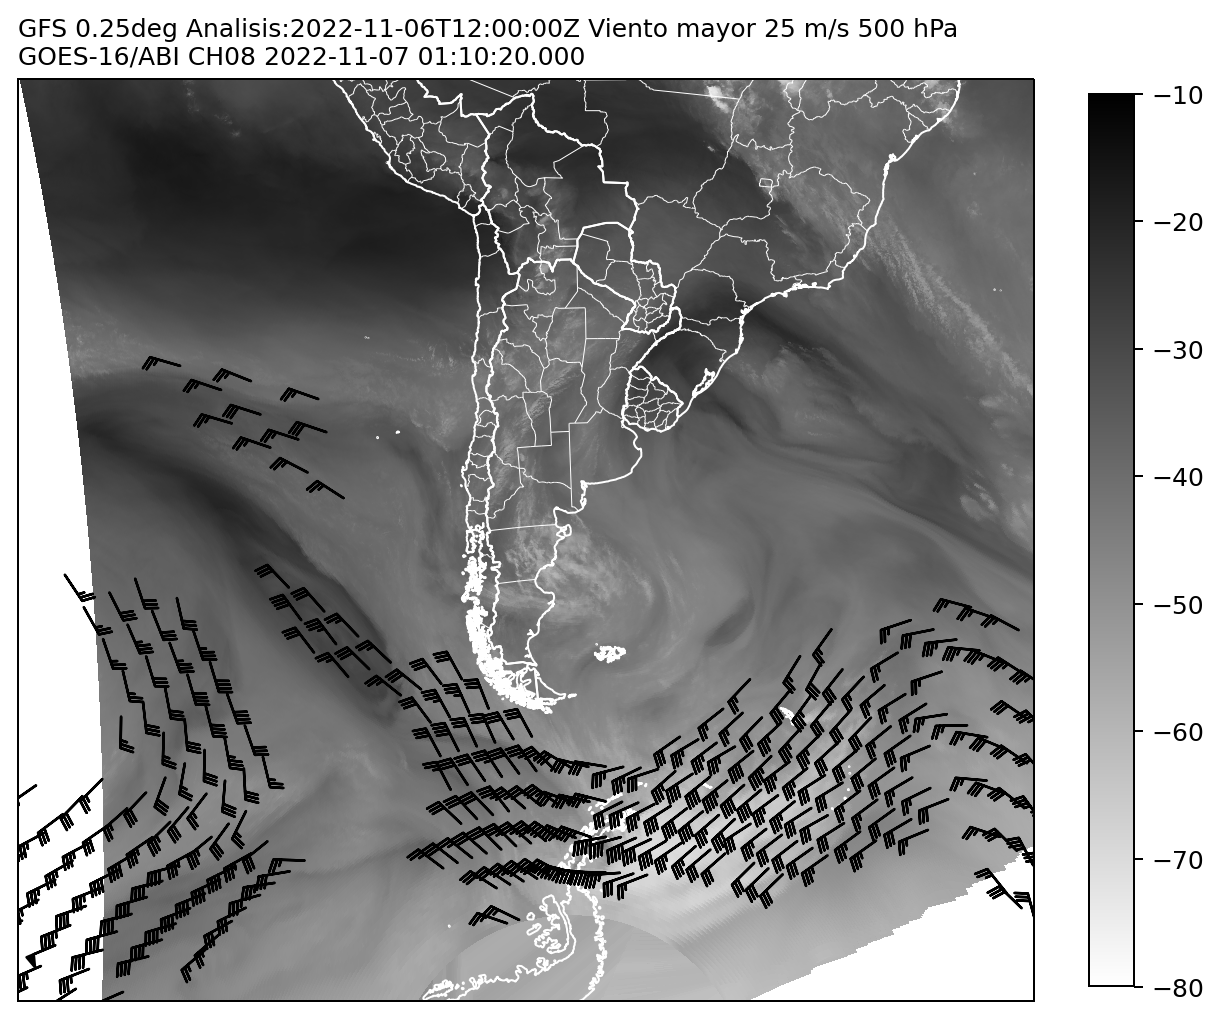

In [12]:
# En este caso se elige una proyección que muestre claramente que los datos
# requeridos de satélite están recortados.

width = 9000.*1000
height = 8000.*1000
extent = [-width*0.55, width*0.4, -height*0.6, height*0.37]
projection = ccrs.Stereographic(central_latitude=-35,
                                central_longitude=-60)

fig, ax = plt.subplots(figsize=(8,8), dpi=180,
                       subplot_kw=dict(projection=projection))
ax.set_extent(extents=extent, crs=projection)

pcm = ax.pcolormesh(sat_lons, sat_lats, sat_data, cmap='gray_r', zorder=-3,
                    vmin=-80, vmax=-10, transform=ccrs.PlateCarree())
fig.colorbar(pcm, ax=ax, fraction=0.04)

# Defino explícitamente cada cuantos puntos quiero graficar las barbas
rs = 10
barb = ax.barbs(xv[::rs, ::rs], yv[::rs, ::rs],
                data_uw_mask[::rs, ::rs], data_vw_mask[::rs, ::rs], 
                fill_empty=True, length=5,
                flip_barb=True, transform=ccrs.PlateCarree())


provincias = cartopy.feature.NaturalEarthFeature(category='cultural',
                                                 name='admin_1_states_provinces_lines',
                                                 scale='10m',
                                                 facecolor='none')
   
paises = cartopy.feature.NaturalEarthFeature(category='cultural',
                                             name='admin_0_countries',
                                             scale='10m',
                                             facecolor='none')
ax.add_feature(provincias, edgecolor='w', linewidth=0.4, zorder=-1)
ax.add_feature(paises, edgecolor='w', linewidth=0.8, zorder=-2)

ax.set_title(f'GFS 0.25deg Analisis:{vtime:%Y-%m-%dT%H:%M:%SZ} Viento mayor 25 m/s 500 hPa\nGOES-16/ABI CH08 {dt_satelite}',
             fontsize=10, loc='left')